In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Replace 'your-zip-file.zip' with the path to your zip file
zip_path = '/content/drive/MyDrive/VisioCoco.zip'

# Replace 'target-folder' with the directory where you want to unzip
target_dir = '/content'

# Creating the target directory if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_dir)

print(f'Unzipped files in {target_dir}')

Unzipped files in /content


In [ ]:
import os
import numpy as np
from skimage import io, color, feature, img_as_float32
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

def process_images_in_batch(image_files, image_folder, label_folder):
    images = []
    labels = []

    for image_file in image_files:
        # Construct the corresponding label file path
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(label_folder, label_file)

        # Read the label
        with open(label_path, 'r') as file:
            label = int(file.readline().strip().split()[0])  # Assuming the first number is the class ID

        # Read and process the image
        image_path = os.path.join(image_folder, image_file)
        img = io.imread(image_path)

        if img is not None:
            img = resize(img, (128, 128), anti_aliasing=True)
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = img_as_float32(color.rgb2gray(img))
            else:
                img = img_as_float32(img)

            hog_features = feature.hog(img)  # Extract HOG features
            images.append(hog_features)
            labels.append(label)

    return images, labels

def train_random_forest_in_batches(image_folder, label_folder, batch_size):
    clf = RandomForestClassifier(n_estimators=100)
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]  # Adjust for your image extension

    for i in range(0, len(image_files), batch_size):
        batch_num = i // batch_size + 1
        total_batches = (len(image_files) + batch_size - 1) // batch_size
        #print(f"Processing batch {batch_num}/{total_batches}")
        batch_files = image_files[i:i + batch_size]
        batch_images, batch_labels = process_images_in_batch(batch_files, image_folder, label_folder)
        clf.fit(batch_images, batch_labels)

    return clf

def evaluate_classifier(clf, image_folder, label_folder):
    print("Evaluating the classifier on the test set...")
    test_images, test_labels = process_images_in_batch(os.listdir(image_folder), image_folder, label_folder)
    predictions = clf.predict(test_images)
    print("Classification Report:")
    print(classification_report(test_labels, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, predictions))

train_image_folder = r'/content/VisioCoco/train/images'
train_label_folder = r'/content/VisioCoco/train/labels'
test_image_folder = r'/content/VisioCoco/valid/images'
test_label_folder = r'/content/VisioCoco/valid/labels'
batch_size = 100

print("Training Random Forest Classifier in batches...")
clf = train_random_forest_in_batches(train_image_folder, train_label_folder, batch_size)

evaluate_classifier(clf, test_image_folder, test_label_folder)


Training Random Forest Classifier in batches...
Evaluating the classifier on the test set...
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.82       225
           1       0.81      0.87      0.84       225

    accuracy                           0.83       450
   macro avg       0.83      0.83      0.83       450
weighted avg       0.83      0.83      0.83       450

Confusion Matrix:
[[179  46]
 [ 30 195]]


In [ ]:
def test_images_in_folder(image_folder, classifier):
    predictions = []
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]  # Adjust for your image extension

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(image_folder, image_file)
        img = io.imread(image_path)

        if img is not None:
            img = resize(img, (128, 128), anti_aliasing=True)
            if len(img.shape) == 3 and img.shape[2] == 3:
                img = img_as_float32(color.rgb2gray(img))
            else:
                img = img_as_float32(img)

            hog_features = feature.hog(img)  # Extract HOG features
            prediction = classifier.predict([hog_features])
            predictions.append(prediction[0])
            print(f"Image {idx+1} ({image_file}): Predicted class = {prediction[0]}")

    return predictions

# Path to test image folder
test_image_folder = '/content/VisioCoco/test'

print("Testing images in folder...")
predicted_classes = test_images_in_folder(test_image_folder, clf)


Testing images in folder...
Image 1 (Anafi_Extended_Evening (1199).jpg): Predicted class = 0
Image 2 (Anafi_Extended_Evening (1160).jpg): Predicted class = 0
Image 3 (foto04728_png.rf.301db30c9b42cb481a5d1e0288ecb1e7.jpg): Predicted class = 0
Image 4 (000000558765.jpg): Predicted class = 1
Image 5 (Anafi_Extended_Evening (1140).jpg): Predicted class = 0
Image 6 (DJI_FPV_Evening (1185).jpg): Predicted class = 0
Image 7 (foto00117_png.rf.403f778b26778cf37e87b8d7703a2a30.jpg): Predicted class = 1
Image 8 (Anafi_Extended_Evening (1174).jpg): Predicted class = 0
Image 9 (000000543713.jpg): Predicted class = 1
Image 10 (000000558169.jpg): Predicted class = 1
Image 11 (moto11688_png.rf.b101d1ee77aca4007fa3da5e294d0525.jpg): Predicted class = 1
Image 12 (0072_jpg.rf.80aab9db388262a4d5e2f529d70920f3.jpg): Predicted class = 0
Image 13 (Anafi_Extended_Evening (1157).jpg): Predicted class = 0
Image 14 (000000545292.jpg): Predicted class = 1
Image 15 (foto01422_png.rf.5c6327c76e714f34cf27cd47911dc6

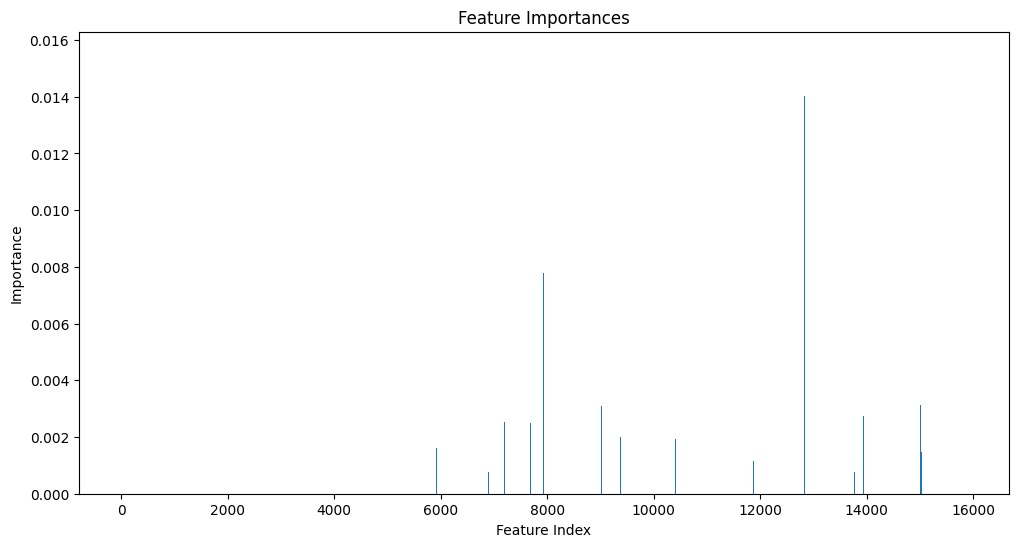

In [ ]:
import matplotlib.pyplot as plt

feature_importances = clf.feature_importances_
# Assuming you have a reasonable number of features to display
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.title('Feature Importances')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()
